### Displaying basic information about the dataset

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/raw_data.csv')

print(df.head())
print("==" *40)
print(f"the shape of the data: {df.shape}")
print("==" *40)
print(f"the columns of the data: {df.columns}")
print("==" *40)
print(f"the data types of the columns: {df.dtypes}")
print("==" *40)
print(f"the summary statistics of the data:\n {df.describe()}")
print("==" *40)
print(f"the info of the data:\n {df.info()}")

         ID Case Number                    Date                     Block  \
0  10460641    HZ199559  12/31/2015 11:59:00 PM        015XX N KEDZIE AVE   
1  10365064    HZ100370  12/31/2015 11:59:00 PM       075XX S EMERALD AVE   
2  10364662    HZ100006  12/31/2015 11:55:00 PM  079XX S STONY ISLAND AVE   
3  10364740    HZ100010  12/31/2015 11:50:00 PM         024XX W FARGO AVE   
4  10364683    HZ100002  12/31/2015 11:50:00 PM          037XX N CLARK ST   

   IUCR     Primary Type                    Description  \
0  0890            THEFT                  FROM BUILDING   
1  1320  CRIMINAL DAMAGE                     TO VEHICLE   
2  0430          BATTERY  AGGRAVATED: OTHER DANG WEAPON   
3  0820            THEFT                 $500 AND UNDER   
4  0460          BATTERY                         SIMPLE   

      Location Description  Arrest  Domestic  ...  Ward  Community Area  \
0  RESIDENCE PORCH/HALLWAY   False     False  ...  26.0            23.0   
1                   STREET   Fal

### Chicago Crime Dataset - Column Descriptions

| Attribute | Data Type | Description |
| :--- | :--- | :--- |
| **ID** | `Integer` | Unique identifier for the record. |
| **Case Number** | `String` | The Chicago Police Department RD Number (Records Division Number). Unique to the incident. |
| **Date** | `String/DateTime` | Date and time the incident occurred. |
| **Block** | `String` | The address where the incident occurred. Note that the specific street number is partially redacted (e.g., `015XX`) for privacy. |
| **IUCR** | `String` | **Illinois Uniform Crime Reporting** code. A four-digit code that classifies the specific criminal incident. |
| **Primary Type** | `String` | Broad category of the crime (e.g., `THEFT`, `BATTERY`, `NARCOTICS`). |
| **Description** | `String` | Detailed sub-category description of the crime (e.g., `OVER $500`, `SIMPLE`, `TO VEHICLE`). |
| **Location Description** | `String` | Description of the location where the incident occurred (e.g., `STREET`, `APARTMENT`, `SIDEWALK`). |
| **Arrest** | `Boolean` | Indicates whether an arrest was made (`True` or `False`). |
| **Domestic** | `Boolean` | Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act. |
| **Beat** | `Integer` | The smallest police geographic area. A beat is a specific patrol area where police officers are assigned. |
| **District** | `Integer` | Indicates the police district where the incident occurred. Districts are comprised of multiple beats. |
| **Ward** | `Float` | The City Council district (political boundary) where the incident occurred. Chicago has 50 wards. |
| **Community Area** | `Float` | Identifies the community area (neighborhood) where the incident occurred. Chicago has 77 community areas. |
| **FBI Code** | `String` | The crime classification code used for FBI Uniform Crime Reporting (e.g., `06` for Larceny/Theft). |
| **X Coordinate** | `Float` | The x-coordinate of the location (State Plane Illinois East NAD 1983 projection). |
| **Y Coordinate** | `Float` | The y-coordinate of the location (State Plane Illinois East NAD 1983 projection). |
| **Year** | `Integer` | The year the incident occurred. |
| **Updated On** | `String/DateTime` | Date and time the record was last updated in the database. |
| **Latitude** | `Float` | The latitude of the location (WGS84). |
| **Longitude** | `Float` | The longitude of the location (WGS84). |
| **Location** | `String` | A combined tuple of the (Latitude, Longitude) formatted for mapping applications. |

### 1. Checking for Missing Values

In this step, we simply identify the gaps. We will fill or drop them later in the Preprocessing notebook.

In [39]:
# Check for missing values in each column
missing_values = df.isnull().sum()

# Filter to show only columns that actually have missing data
missing_values = missing_values[missing_values > 0]

print(f"Columns with missing values:\n{missing_values}")


Columns with missing values:
Location Description     613
Ward                       2
Community Area            13
X Coordinate            6974
Y Coordinate            6974
Latitude                6974
Longitude               6974
Location                6974
dtype: int64


### 2. Checking for Duplicate Rows
**Why do we do this?**
Duplicate rows can bias our analysis and model. If the same crime is recorded three times, the model will "overlearn" that specific incident. We need to verify if the dataset contains unique records.

In [40]:
# Count duplicate rows
duplicate_count = df.duplicated().sum()

print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 0


### 3. Cardinality and Constant Columns
**Why do we do this?**
1. **Constant Columns:** If a column has only 1 unique value (e.g., every row is "Chicago"), it provides zero information to the model and should be removed.
2. **High Cardinality:** Categorical columns with too many unique values (like `Case Number` or `ID`) act as identifiers, not features. They are usually not useful for prediction.

In [41]:
# Get the number of unique values for each column
unique_counts = df.nunique()

# Check for constant columns (only 1 unique value)
constant_cols = unique_counts[unique_counts == 1]

print(f"Constant columns (candidates for dropping): \n{constant_cols}\n")
print("="*40)
print(f"All unique value counts:\n{unique_counts}")

Constant columns (candidates for dropping): 
Year    1
dtype: int64

All unique value counts:
ID                      264882
Case Number             264855
Date                    112352
Block                    27522
IUCR                       329
Primary Type                32
Description                341
Location Description       140
Arrest                       2
Domestic                     2
Beat                       274
District                    23
Ward                        50
Community Area              77
FBI Code                    26
X Coordinate             51566
Y Coordinate             72738
Year                         1
Updated On                2234
Latitude                131441
Longitude               131415
Location                131462
dtype: int64


### 4. Class Imbalance (Target Variable)
**Why do we do this?**
Since we might want to predict the `Arrest` column (True/False), we need to check if the classes are balanced.
If 90% of crimes result in `False` (no arrest) and only 10% in `True`, our model will be biased. Knowing this now helps us decide if we need techniques like oversampling later.

Class Distribution for 'Arrest':
Arrest
False    73.544069
True     26.455931
Name: proportion, dtype: float64


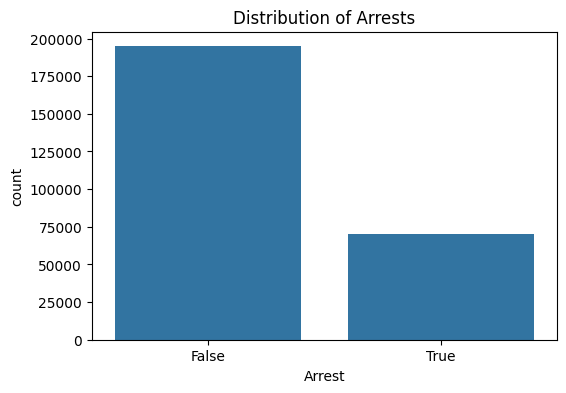

In [42]:
# Check the distribution of the target variable 'Arrest'
arrest_counts = df['Arrest'].value_counts(normalize=True) * 100

print(f"Class Distribution for 'Arrest':\n{arrest_counts}")

# Visualize it
plt.figure(figsize=(6, 4))
sns.countplot(x='Arrest', data=df)
plt.title("Distribution of Arrests")
plt.show()

### 5. Detecting Outliers
**Why do we do this?**
Outliers are extreme values that deviate significantly from the rest of the data. They could be:
1. **Errors:** A latitude of 900 (impossible).
2. **Rare Events:** A theft of $1,000,000.

We use boxplots to visualize the spread of numerical data like Coordinates.

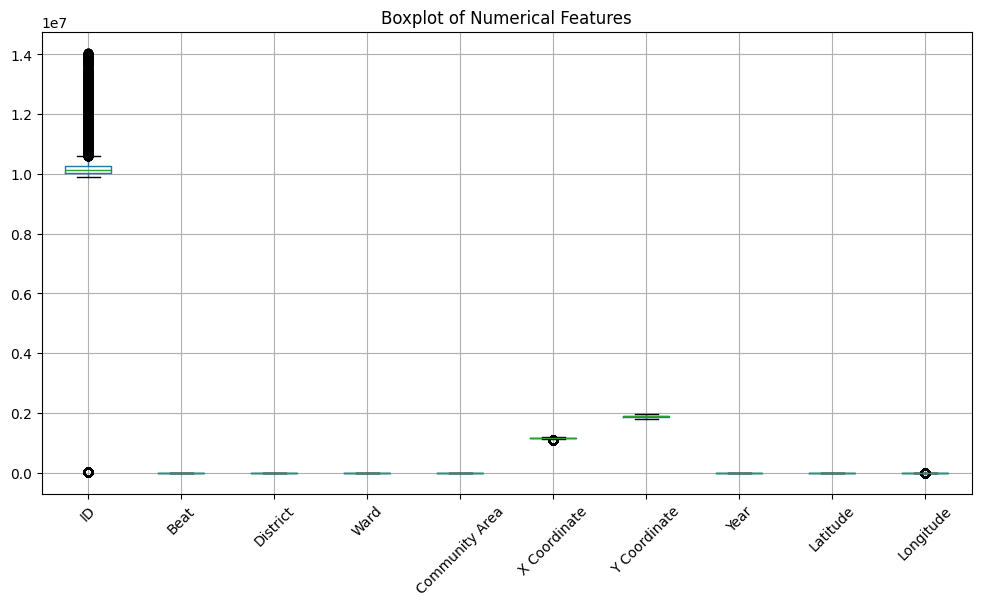

In [45]:


# Automatically select all numerical columns (floats and ints)
# This replaces the manual list: ['X Coordinate', 'Y Coordinate', 'Ward', 'District']
num_cols = df.select_dtypes(include=['number']).columns

# Optional: If you want to exclude specific ID columns usually labeled 'ID'
# num_cols = [col for col in num_cols if 'ID' not in col]

plt.figure(figsize=(12, 6))
# passing the columns directly to boxplot
df[num_cols].boxplot()
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=45)
plt.show()

### 6. Inconsistent Categories
**Why do we do this?**
In columns like `Primary Type`, human error often leads to typos (e.g., "THEFT", "Theft", "theft "). We check the unique values to see if we need to clean strings (lowercase, strip whitespace) later.

In [47]:
# Check unique values in a text-based column
print("Unique values in 'Primary Type':")
print(df['Primary Type'].unique())

print("\n" + "="*40 + "\n")

print("Unique values in 'Location Description':")
# displaying just the top 10 most common to avoid spamming the output
print(df['Location Description'].value_counts().head(10))

Unique values in 'Primary Type':
['THEFT' 'CRIMINAL DAMAGE' 'BATTERY' 'OTHER OFFENSE' 'MOTOR VEHICLE THEFT'
 'ROBBERY' 'WEAPONS VIOLATION' 'CRIMINAL SEXUAL ASSAULT' 'ASSAULT'
 'BURGLARY' 'CRIM SEXUAL ASSAULT' 'DECEPTIVE PRACTICE' 'NARCOTICS'
 'CRIMINAL TRESPASS' 'OFFENSE INVOLVING CHILDREN'
 'INTERFERENCE WITH PUBLIC OFFICER' 'SEX OFFENSE' 'ARSON'
 'PUBLIC PEACE VIOLATION' 'PROSTITUTION' 'LIQUOR LAW VIOLATION' 'HOMICIDE'
 'INTIMIDATION' 'KIDNAPPING' 'OBSCENITY' 'STALKING' 'PUBLIC INDECENCY'
 'CONCEALED CARRY LICENSE VIOLATION' 'GAMBLING' 'HUMAN TRAFFICKING'
 'OTHER NARCOTIC VIOLATION' 'NON-CRIMINAL']


Unique values in 'Location Description':
Location Description
STREET                            60755
RESIDENCE                         41907
APARTMENT                         35100
SIDEWALK                          27875
OTHER                             10596
PARKING LOT/GARAGE(NON.RESID.)     7428
ALLEY                              5616
RESIDENTIAL YARD (FRONT/BACK)      5511
SMALL RE